In [185]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Simple Confidence Plot

In [188]:
DATA_PATH="/mnt/d/books/iitm/phd/offline_mpc/weighted_bc"

In [27]:
def convert_to_melt_df(algo, task, type, algo_name):
    # load csv to dataframe
    path = f"{DATA_PATH}/{algo}/{task}/{type}"
    abs_filenames = sorted([osp.join(path, f) for f in os.listdir(path)])
    dfs = []
    for i, f in enumerate(abs_filenames):
        d = pd.read_csv(f)
        if "Wall time" not in d.columns:
            continue 
        d = d.drop(columns=["Wall time"]).rename(columns={"Value": f"seed_{i}", "Step": "epoch"})
        dfs.append(d)
 
    # join dataframes based on epoch
    df = dfs[0]
    for d in dfs[1:]:
        df = df.join(d.set_index("epoch"), on="epoch")
        
    df = pd.melt(df, id_vars=["epoch"], var_name="algo_name", value_name=type)
    df["algo_name"] = algo_name
    return df

In [4]:
task = "Point_Circle1"
type = "ep_cost"

# positive_bc_df = convert_to_melt_df("positive_bc", task, type, "positive_bc")
mix_50p_01_df = convert_to_melt_df("50p_mix_0.1", task, type, "50p_bc_0.1")
mix_50p_03_df = convert_to_melt_df("50p_mix_0.3", task, type, "50p_bc_0.3")
mix_50p_05_df = convert_to_melt_df("50p_mix_0.5", task, type, "50p_bc_0.5")
mix_50p_07_df = convert_to_melt_df("50p_mix_0.7", task, type, "50p_bc_0.7")

In [6]:
d = pd.concat([mix_50p_01_df, mix_50p_03_df, mix_50p_05_df, mix_50p_07_df], ignore_index=True, sort=False)

Text(0.5, 1.0, 'Point_Circle1')

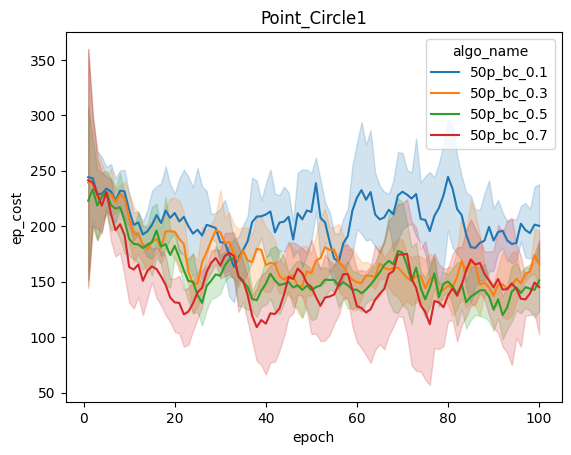

In [7]:
fig, ax = plt.subplots()

sns.lineplot(ax=ax, data=d, x="epoch", y=type, hue="algo_name")
sns.move_legend(ax, "upper right")
ax.set_title(task)

In [43]:
save_fig_path = f"{DATA_PATH}/svg_images/{task}_{type}.svg"
fig.savefig(save_fig_path, format="svg")

In [ ]:
save_fig_path = f"{DATA_PATH}/png_images/{task}_{type}.png"
fig.savefig(save_fig_path)

### Bootstrap Confidence Interval

In [186]:
# DATA_PATH = "/mnt/d/books/iitm/phd/offline_mpc/weighted_bc"
DATA_PATH = "/home/returaj/Documents/research/offline_safe_rl"

In [187]:
def load_data_as_array(algo, task, fields,type):
    # load csv to dataframe
    path = f"{DATA_PATH}/{algo}/{task}/{fields}/{type}"
    abs_filenames = sorted([osp.join(path, f) for f in os.listdir(path)])
    dfs = []
    for i, f in enumerate(abs_filenames):
        d = pd.read_csv(f)
        if "Wall time" not in d.columns:
            continue 
        d = d.drop(columns=["Wall time"]).rename(columns={"Value": f"seed_{i}", "Step": "epoch"})
        dfs.append(d)
 
    # join dataframes based on epoch
    df = dfs[0]
    for d in dfs[1:]:
        df = df.join(d.set_index("epoch"), on="epoch")
    
    # num_seeds X T
    arr = df.drop(columns=["epoch"]).to_numpy().T
    return arr

In [188]:
def bootstrap_confidence_interval(data, n_bootstrap=1000, confidence_level=0.95):
    """
    Function to compute bootstrap confidence intervals for time-series data and plot the results.
    
    Parameters:
    data (list of array-like): List of n time-series datasets (arrays) of the same length.
    n_bootstrap (int): Number of bootstrap resamples.
    confidence_level (float): Confidence level for the interval (default is 0.95).
    
    Returns:
    mean, lower_bound, upper_bound: The lower and upper bounds of the confidence interval at each time step.
    """
    # Convert data to numpy array (shape: 5 x T, where T is the number of time steps)
    data = np.array(data)
    
    # Ensure all time-series are of the same length
    assert len(set([len(ts) for ts in data])) == 1, "All time-series must be of the same length!"
    
    # Number of time steps
    num_data, T = data.shape
    
    # Arrays to store bootstrap results
    bootstrapped_means = np.zeros((n_bootstrap, T))
    
    # Perform bootstrap resampling for each time step
    for i in range(n_bootstrap):
        # Resample with replacement from the num_data time-series at each time step
        resampled_indices = np.random.choice(num_data, (num_data,), replace=True)
        bootstrapped_means[i, :] = np.mean(data[resampled_indices], axis=0)
    
    # Compute the confidence interval at each time step
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrapped_means, 100 * alpha, axis=0)
    upper_bound = np.percentile(bootstrapped_means, 100 * (1 - alpha), axis=0)
    
    mean_time_series = np.mean(bootstrapped_means, axis=0)

    return mean_time_series, lower_bound, upper_bound

In [189]:
def light_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]  # convert named color to hex
    except KeyError:
        c = color  # if it's not a named color, it might already be hex or RGB

    rgb = mcolors.to_rgb(c)  # convert to RGB format
    light_color = [(1 - amount) * channel + amount for channel in rgb]  # blend with white
    return light_color

def plot_confidence_interval(means, lowers, uppers, labels, colors, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(6, 4))
    T = len(means[0])
    x = np.arange(T) + 1
    for m, l, u, label, c in zip(means, lowers, uppers, labels, colors):
        ax.plot(x, m, color=c, lw=2, label=label)
        ax.fill_between(range(T), l, u, color=light_color(c), alpha=0.4)
    
    ax.set_title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylabel in ("ep_reward", "ep_valid_bc"):
        ax.legend(loc='upper right') 
    return fig, ax

In [190]:
BASE_COLORS = ["blue", "green", "red", "orange", "yellow", "pink", "magenta", "purple"]

In [ ]:
task = "Hopper_Velocity"
type = "ep_cost"
algo = "weighted_bc_1"

fields_name = ["cw_0.6_th_3", "cw_0.6_th_10"] + ["cw_0.9_th_3", "cw_0.9_th_10"]
colors = BASE_COLORS[:len(fields_name)]

means, lowers, uppers = [], [], []
for f in fields_name:
    # print(f)
    data = load_data_as_array(algo, task, f, type)
    m, l, u = bootstrap_confidence_interval(data)
    means.append(m)
    lowers.append(l)
    uppers.append(u)

In [ ]:
fig, ax = plot_confidence_interval(means, lowers, uppers, labels=fields_name, colors=colors, title=task, xlabel="epochs", ylabel=type)

In [88]:
# save_fig_path = f"{DATA_PATH}/svg_images/{task}_{type}.svg"
# fig.savefig(save_fig_path, format="svg")

In [89]:
save_fig_path = f"{DATA_PATH}/png_images/{task}_{type}.png"
fig.savefig(save_fig_path)